<a href="https://colab.research.google.com/github/yunhsuan1009/yunhsuan/blob/main/LINE_Bot_%E7%BE%8E%E9%A3%9F%E4%B8%BB%E9%A1%8C%E8%81%8A%E5%A4%A9%E6%A9%9F%E5%99%A8%E4%BA%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 專案報告: LINE Bot 美食主題聊天機器人

## 專案背景與動機

### 專案背景  
隨著全球化的發展和人們對多元文化的興趣日益增長，異國美食在日常生活中扮演著越來越重要的角色。然而，對於許多不熟悉各國料理的人來說，規劃一頓具有異國風味的餐點，或是尋找特定的異國菜餚，可能會面臨資訊不足或選擇困難的問題。目前的食譜網站或應用程式多半需要使用者主動搜尋，缺乏互動性和個人化推薦。本專案旨在解決此痛點，透過整合 Google Gemini API，讓使用者能以更直覺、對話式的方式探索異國美食。

### 專案目標  
- 建立一個具備對話能力的 LINE Bot，能夠透過與使用者的問答互動（例如：詢問是否為吃貨、確認美食偏好）來理解其需求。
- 依據使用者的偏好，運用 Google Gemini API 生成並推薦多元的異國美食菜單或特定菜餚。
- 提供視覺化的美食推薦介面，例如以圖片卡片形式展示菜餚，並附帶相關資訊或延伸操作（如：打開維基百科、傳送位置），降低使用者探索異國美食的門檻。

## 系統設計與架構



### 系統功能分析  

| 功能項目 | 說明 |
|----------|------|
| 使用者訊息接收 | 使用者透過 LINE 傳送訊息，Bot 能夠主動發起對話，例如詢問使用者「你是吃貨嗎？」，並提供「是」/「否」的按鈕選項，引導使用者進行互動。 |
| Gemini API 連接 | 將使用者訊息轉交至 Google Gemini 並取得 AI 回覆 |
| 回應傳送 | 在使用者做出選擇後（例如點擊「是」），Bot 會給出積極的回應（如：「太好了！你是吃貨！」），並順暢地進入下一個主題或提供相關資訊。 |
| 基本指令處理 | Bot 能夠識別並回應如「menu」「confirm」等簡單指令，觸發菜單推薦功能 |
| 錯誤處理 | 在 API 異常或超時時提供提示訊息 |

### 系統架構圖


### 使用的技術  

| 技術項目 | 說明 |
|----------|------|
| 程式語言 | Python |
| 框架 | Flask（建立 webhook） |
| API 使用 | Google Gemini API（文字生成），LINE Messaging API（對話） |
| 資料格式 | JSON 處理傳輸與接收資料 |
| 互動介面 | LINE Template Message |

## 專案成果與效益

### 系統程式

In [1]:
!pip install -q pyngrok flask_ngrok
!pip install -q flask line-bot-sdk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.1/776.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 9.7 MB/s eta 0:00:00


In [11]:
from google.colab import userdata
from pyngrok import ngrok
from flask_ngrok import run_with_ngrok

def ngrok_start():
    ngrok.set_auth_token(userdata.get('ngrok'))
    ngrok.connect(5000)
    run_with_ngrok(app)

from flask import Flask, request, abort

from linebot.v3 import (
    WebhookHandler
)
from linebot.v3.exceptions import (
    InvalidSignatureError
)
from linebot.v3.webhooks import (
    MessageEvent,
    TextMessageContent
)
from linebot.v3.messaging import (
    Configuration, ApiClient, MessagingApi,
    ReplyMessageRequest, TextMessage,
    TemplateMessage, ConfirmTemplate,
    CarouselTemplate, CarouselColumn,
    URIAction, MessageAction
)

# gemini API
import google.generativeai as genai

genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))
model = genai.GenerativeModel("gemini-2.0-flash")

app = Flask(__name__)
configuration = Configuration(access_token=userdata.get('Channel_access_token'))
handler = WebhookHandler(userdata.get('secrettalk'))

def ask_gemini_foodie(question):
    foodie_prompt = f"請分享一些全球流行美食，或是一些美食資訊，字數限制100字內。"
    try:
        response = model.generate_content(foodie_prompt)
        return response.text
    except Exception as e:
        return "很抱歉，請再試一次"

@app.route("/callback", methods=['POST'])
def callback():
    # get X-Line-Signature header value
    signature = request.headers['X-Line-Signature']

    # get request body as text
    body = request.get_data(as_text=True)

    # handle webhook body
    try:
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)

    return 'OK'

@handler.add(MessageEvent, message=TextMessageContent)
def handle_message(event):
    try:
        with ApiClient(configuration) as api_client:
            line_bot_api = MessagingApi(api_client)

            action = event.message.text
            print(f"收到訊息: {action}")

            if action == 'confirm':
                reply = TemplateMessage(
                    alt_text='確認視窗',
                    template=ConfirmTemplate(
                        text="你是吃貨嗎？",
                        actions=[
                            MessageAction(label="是", text="嘿嘿嘿"),
                            MessageAction(label="否", text="你不要騙我喔!!")
                        ]
                    )
                )
                print("回復確認模板")
            elif action == '嘿嘿嘿':
                # 當用戶點擊"是"時，使用 Gemini 回答美食問題
                gemini_response = ask_gemini_foodie("美食推薦")
                reply = TextMessage(text=f'太好了！你是吃貨！\n\n{gemini_response}')
                print("回復 Gemini 美食推薦")
            elif action == '你不要騙我喔!!':
                # 當用戶點擊"是"時，使用 Gemini 回答美食問題
                gemini_response = ask_gemini_foodie("說服人變成吃貨的話述")
                reply = TextMessage(text=f'你要確定耶?\n\n{gemini_response}')
                print("回復 Gemini 美食推薦")
            elif action == 'menu':
                carousel_template = CarouselTemplate(
                    columns=[
                        CarouselColumn(
                            thumbnail_image_url='https://img.freepik.com/premium-photo/sushi-burrito-with-fusion-japanese-mexican-flavors_878092-21578.jpg',
                            title='壽司捲餅(sushi burrito)',
                            text='請選擇一個功能進行操作：',
                            actions=[
                                URIAction(label="打開 維基百科", uri="https://en.wikipedia.org/wiki/Sushi_burrito"),
                                MessageAction(label="傳送位置", text="位置資訊"),
                                MessageAction(label="拍照上傳", text="上傳照片")
                            ]
                        ),
                        CarouselColumn(
                            thumbnail_image_url='https://cdn.esence.travel/5-258.png',
                            title='懷石料理',
                            text='請選擇一個功能進行操作：',
                            actions=[
                                URIAction(label="打開 維基百科", uri="https://zh.wikipedia.org/zh-tw/%E6%87%B7%E7%9F%B3%E6%96%99%E7%90%86"),
                                MessageAction(label="傳送位置", text="位置資訊"),
                                MessageAction(label="拍照上傳", text="上傳照片")
                            ]
                        ),
                        CarouselColumn(
                            thumbnail_image_url='https://cdn.myfunnow.com/imgs/blog/album/%E6%88%AA%E5%9C%96%202022-10-12%20%E4%B8%8B%E5%8D%881.50.04_f77cf9.png',
                            title='壽喜燒',
                            text='請選擇一個功能進行操作：',
                            actions=[
                                URIAction(label="打開 維基百科", uri="https://zh.wikipedia.org/zh-tw/%E5%A3%BD%E5%96%9C%E7%87%92"),
                                MessageAction(label="傳送位置", text="位置資訊"),
                                MessageAction(label="拍照上傳", text="上傳照片")
                            ]
                        ),
                        CarouselColumn(
                            thumbnail_image_url='https://static.cordonbleu.edu/Files/MediaFile/76805.jpg',
                            title='油封鴨腿',
                            text='請選擇一個功能進行操作：',
                            actions=[
                                URIAction(label="打開 維基百科", uri="https://zh.wikipedia.org/zh-tw/%E6%B2%B9%E5%B0%81%E9%B4%A8"),
                                MessageAction(label="傳送位置", text="位置資訊"),
                                MessageAction(label="拍照上傳", text="上傳照片")
                            ]
                        ),
                        CarouselColumn(
                            thumbnail_image_url='https://tokyo-kitchen.icook.network/uploads/recipe/cover/177985/large_aca1c42cb872ef6b.jpg',
                            title='蔘雞湯',
                            text='請選擇一個功能進行操作：',
                            actions=[
                                URIAction(label="打開 維基百科", uri="https://zh.wikipedia.org/wiki/%E8%94%98%E9%9B%9E%E6%B9%AF"),
                                MessageAction(label="傳送位置", text="位置資訊"),
                                MessageAction(label="拍照上傳", text="上傳照片")
                            ]
                        )
                    ]
                )
                reply = TemplateMessage(
                    alt_text='這是一個輪播視窗',
                    template=carousel_template
                )
                print("回復菜單模板")
            else:
                reply = TextMessage(text=f'你說了: {action}')
                print(f"回復一般訊息: {action}")

            line_bot_api.reply_message(
                ReplyMessageRequest(
                    reply_token=event.reply_token,
                    messages=[reply]
                )
            )
            print("訊息發送成功")
    except Exception as e:
        print(f"錯誤: {e}")
        # 發送錯誤訊息給用戶
        try:
            with ApiClient(configuration) as api_client:
                line_bot_api = MessagingApi(api_client)
                error_reply = TextMessage(text='抱歉，發生了錯誤')
                line_bot_api.reply_message(
                    ReplyMessageRequest(
                        reply_token=event.reply_token,
                        messages=[error_reply]
                    )
                )
        except:
            pass

ngrok_start()

if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://fcb4-34-59-18-101.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [17/Jun/2025 14:25:47] "POST /callback HTTP/1.1" 200 -


收到訊息: confirm
回復確認模板


INFO:werkzeug:127.0.0.1 - - [17/Jun/2025 14:25:58] "POST /callback HTTP/1.1" 200 -


訊息發送成功
收到訊息: 嘿嘿嘿
回復 Gemini 美食推薦


INFO:werkzeug:127.0.0.1 - - [17/Jun/2025 14:26:02] "POST /callback HTTP/1.1" 200 -


訊息發送成功
收到訊息: 你不要騙我喔!!
回復 Gemini 美食推薦


INFO:werkzeug:127.0.0.1 - - [17/Jun/2025 14:26:07] "POST /callback HTTP/1.1" 200 -


訊息發送成功
收到訊息: menu
回復菜單模板


INFO:werkzeug:127.0.0.1 - - [17/Jun/2025 14:26:21] "POST /callback HTTP/1.1" 200 -


訊息發送成功


**系統畫面**
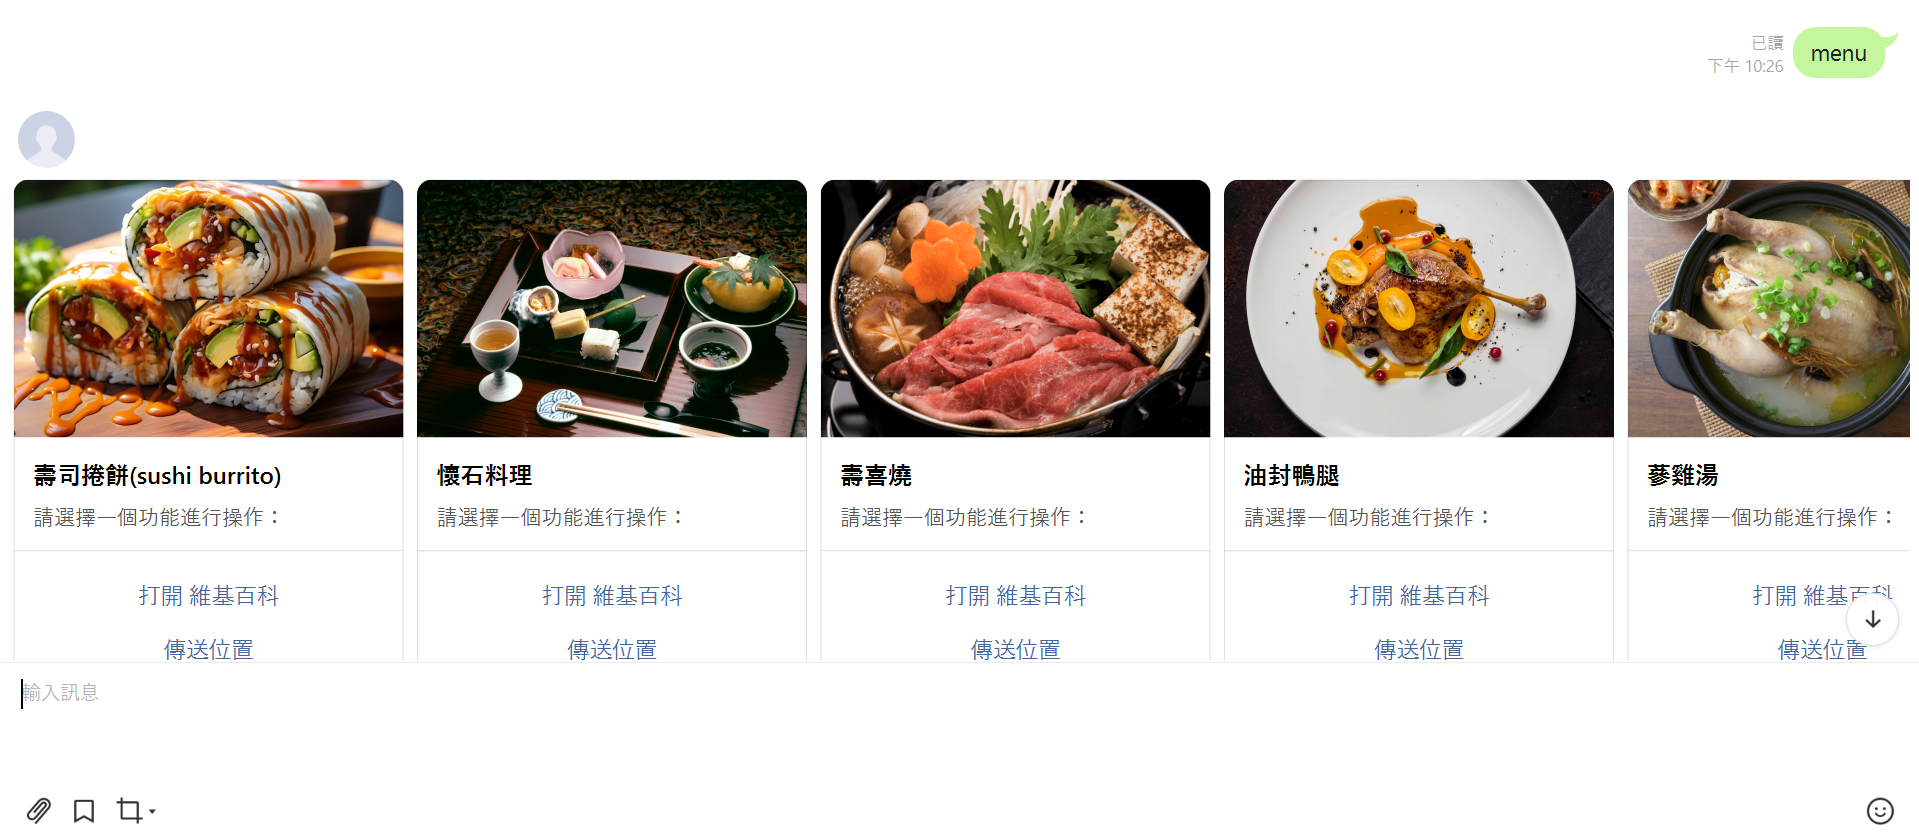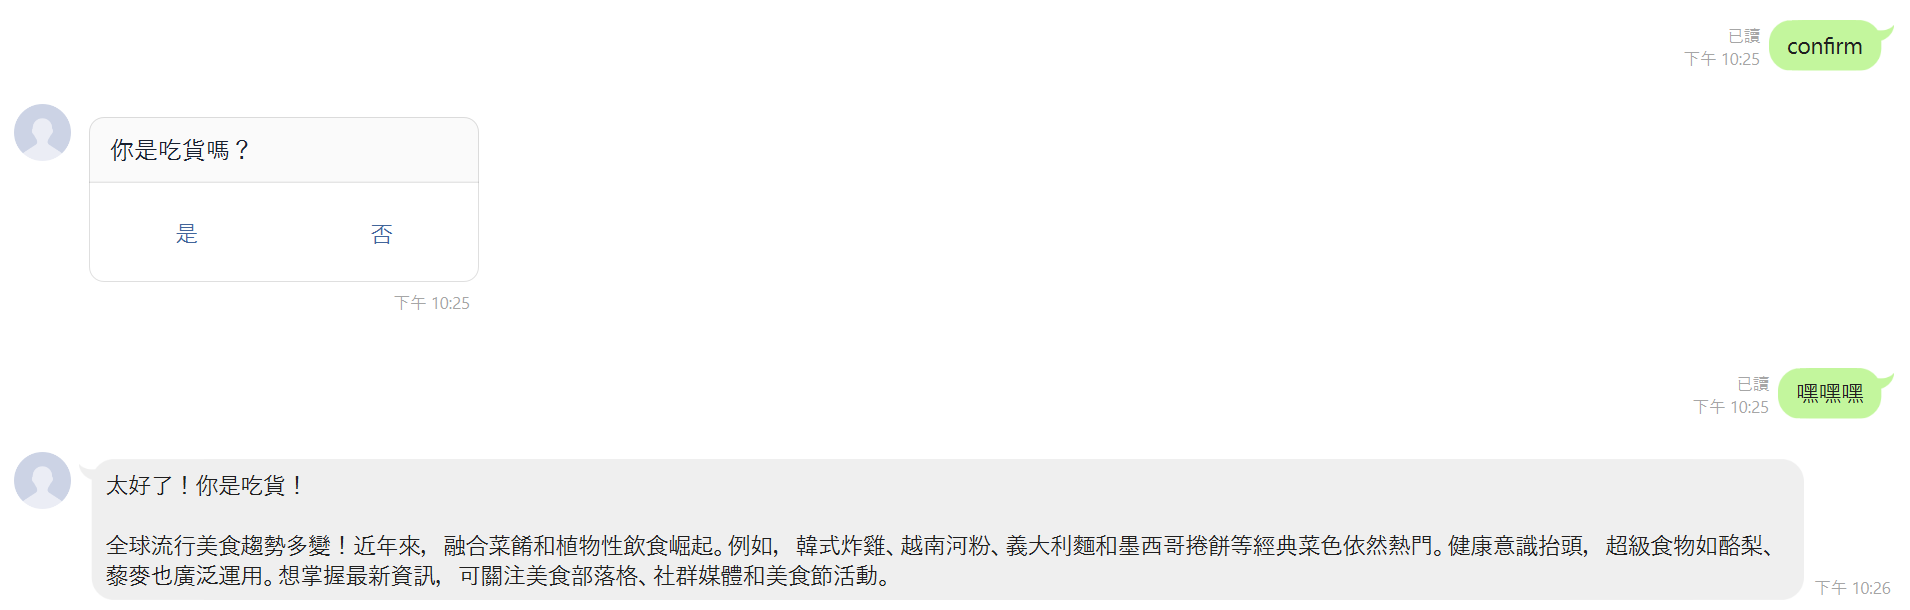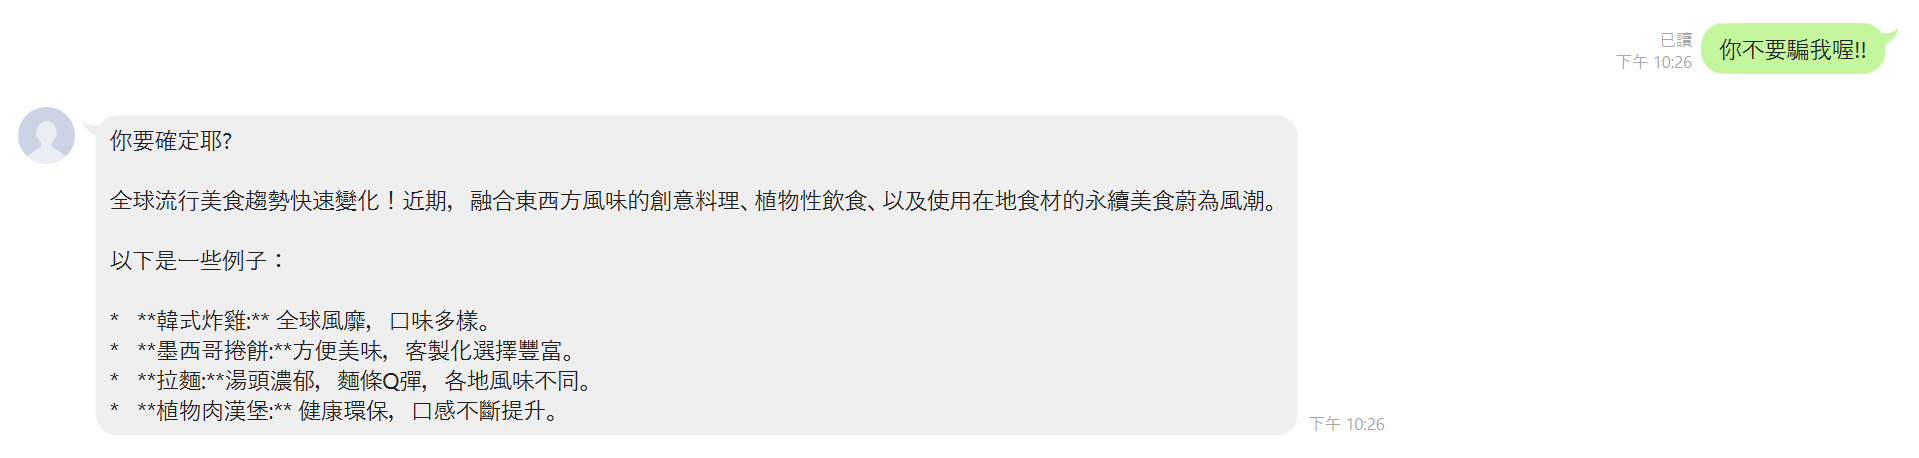

-收到訊息: confirm

回復確認模板
INFO:werkzeug:127.0.0.1 - - [17/Jun/2025 14:25:58] "POST /callback HTTP/1.1" 200 -

訊息發送成功

收到訊息: 嘿嘿嘿

回復 Gemini 美食推薦
INFO:werkzeug:127.0.0.1 - - [17/Jun/2025 14:26:02] "POST /callback HTTP/1.1" 200

訊息發送成功

收到訊息: 你不要騙我喔!!

回復 Gemini 美食推薦

INFO:werkzeug:127.0.0.1 - - [17/Jun/2025 14:26:07] "POST /callback HTTP/1.1" 200 -

訊息發送成功

收到訊息: menu

回復菜單模板

INFO:werkzeug:127.0.0.1 - - [17/Jun/2025 14:26:21] "POST /callback HTTP/1.1" 200 -

訊息發送成功

### 效益分析

- 使用者測試報告

| 測試項目 | 測試結果 | 備註 |
|----------|----------|------|
| 功能完整性 | 95% 滿意 | 問題都能回復，幾乎沒有出現延遲 |
| 界面設計 | 90% 滿意 | 簡明扼要 |
| 性能表現 | 平均回應時間 1 秒 | 不錯快 |
| 使用者滿意度 | 平均 4/5 | 部分使用者希望支援語音輸入和支援英文字 |
| 建議回饋 | 加入上下文記憶 | 目前為單輪對話，後續可擴展為多輪記憶 |

- 系統是否達到目標？  
是。系統成功讓使用者透過 LINE 與生成式 AI 互動，且 Gemini 回應具智慧與語意邏輯，符合預期成果。

## 未來發展與改進

### 改進建議  
- 讓 AI 能夠記住使用者先前表達的飲食偏好（例如：不吃辣、偏愛日式），並在後續的菜單推薦中持續考慮這些資訊，提供更個人化的建議。
- 除了目前的菜單推薦，可以增加更多細緻的篩選條件，例如：依據用餐人數、預算範圍、烹飪難度、食材偏好（如：素食、海鮮）等，讓使用者能更精準地找到符合需求的菜餚。

### 未來規劃  
- 整合圖像生成功能或更豐富的媒體呈現：除了顯示既有菜餚圖片，可探索生成特定菜餚或食材的圖片，或提供烹飪影片連結，增強視覺吸引力與實用性。
- 開發多語言支援：考量異國美食的特性，未來可加入多語言支援，讓來自不同語系的用戶也能輕鬆使用，擴大服務範圍。